In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

drive  sample_data


In [0]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
import keras

num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

  
  



def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
     
    
    
    
    input_img = Input(shape = (28, 28, 1))
    tower_1 = Conv2D(64, (1,1), padding='same', activation='elu')(input_img)
    tower_x = Conv2D(64, (3,3), padding='same', activation='elu')(tower_1)
    tower_y = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_x)
    tower_y = Dropout(0.25)(tower_y)
    tower_z = Conv2D(64, (1,1), padding='same', activation='elu')(tower_y)
    tower_a = Conv2D(64, (3,3), padding='same', activation='elu')(tower_z)
    tower_a = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_a)
    tower_a = Dropout(0.25)(tower_a)
    
  
    tower_2 = MaxPooling2D(pool_size=(4, 4), padding='same')(tower_x)
    tower_2 = Dropout(0.25)(tower_2)
    
    tower_3 = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_z)
    tower_3 = Dropout(0.25)(tower_3)
    
    
#     tower_3 = Conv2D(64, (1,1), padding='same', activation='elu')(input_img)
#     tower_3 = Conv2D(64, (5,5), padding='same', activation='elu')(tower_3)
#     tower_3 = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_3)
#     tower_3 = Dropout(0.25)(tower_3)
    
#     tower_4 = MaxPooling2D(pool_size=(2, 2), padding='same')(input_img)
#     tower_4 = Dropout(0.25)(tower_4)
    
    
    
    
    
    
    output = keras.layers.concatenate([tower_a, tower_2, tower_3], axis = 3)
    output = Flatten()(output)
#     out    = Dense(10, activation='softmax')(output)
    out    = Dense(128, activation='softmax')(output)
    
   

    
    
    
    
    model = Model(inputs = input_img, outputs = out)
    print(model.summary())
    return model
    

  
  


  

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.astype('float32')
x_test = x_test.reshape(10000,28,28,1)
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

hist = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_po

In [0]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
import keras
from keras.optimizers import RMSprop, adam
from keras import optimizers

num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

  
  



def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
     
    
    
    
    input_img = Input(shape = (28, 28, 1))
    tower_1 = Conv2D(64, (1,1), padding='same', activation='elu')(input_img)
    tower_x = Conv2D(64, (3,3), padding='same', activation='elu')(tower_1)
    tower_y = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_x)
    tower_y = Dropout(0.25)(tower_y)
    tower_z = Conv2D(64, (1,1), padding='same', activation='elu')(tower_y)
    tower_a = Conv2D(64, (3,3), padding='same', activation='elu')(tower_z)
    tower_a = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_a)
    tower_a = Dropout(0.25)(tower_a)
    
  
    tower_2 = MaxPooling2D(pool_size=(4, 4), padding='same')(tower_x)
    tower_2 = Dropout(0.25)(tower_2)
    
    tower_3 = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_z)
    tower_3 = Dropout(0.25)(tower_3)
    
    
#     tower_3 = Conv2D(64, (1,1), padding='same', activation='elu')(input_img)
#     tower_3 = Conv2D(64, (5,5), padding='same', activation='elu')(tower_3)
#     tower_3 = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_3)
#     tower_3 = Dropout(0.25)(tower_3)
    
#     tower_4 = MaxPooling2D(pool_size=(2, 2), padding='same')(input_img)
#     tower_4 = Dropout(0.25)(tower_4)
    
    
    
    
    
    
    output = keras.layers.concatenate([tower_a, tower_2, tower_3], axis = 3)
    output = Flatten()(output)
#     out    = Dense(10, activation='softmax')(output)
    out    = Dense(64, activation='softmax')(output)
    
   

    
    
    
    
    model = Model(inputs = input_img, outputs = out)
    print(model.summary())
    return model
    

  
  


  

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.astype('float32')
x_test = x_test.reshape(10000,28,28,1)
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
# rms = RMSprop()
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=contrastive_loss, optimizer=adam, metrics=[accuracy])

hist = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 64)   128         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 64)   36928       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 14, 14, 64)   0           conv2d_6[0][0]                   
____________________________________________________________________________________________

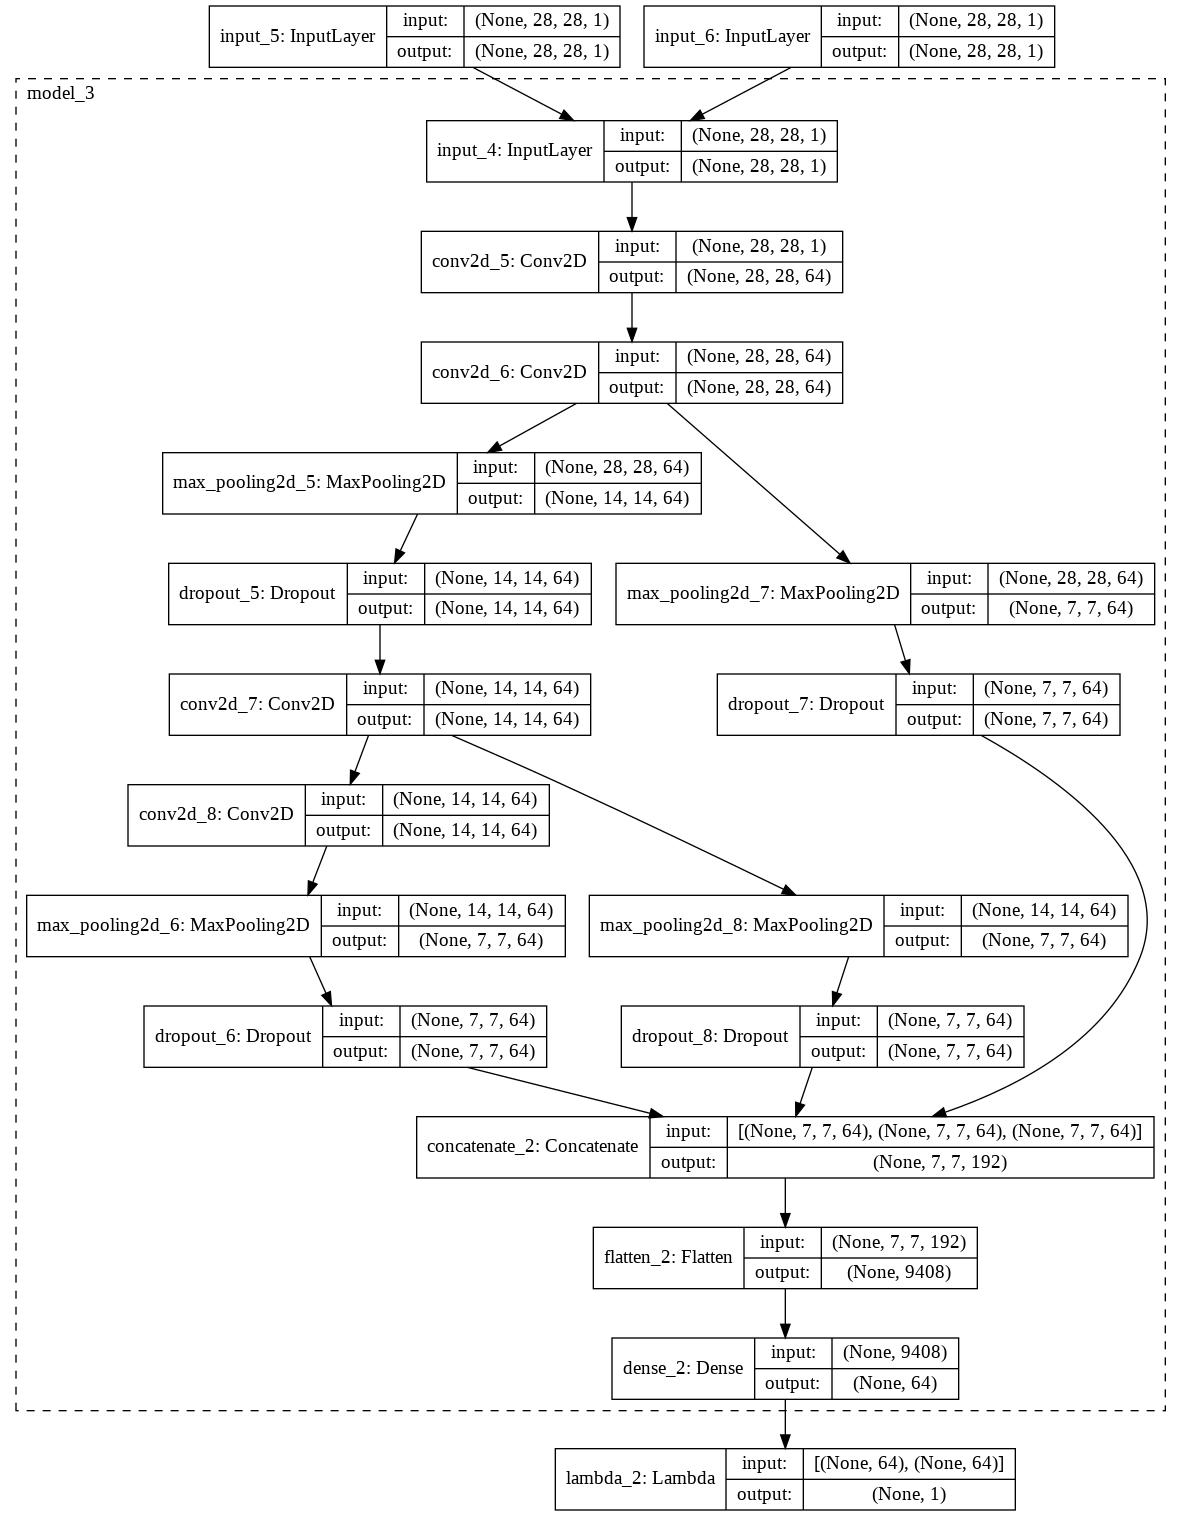

In [0]:


from keras.utils.vis_utils import plot_model

plot_model(model, to_file='accurate.png',show_shapes=True, show_layer_names=True,expand_nested=True)

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
  6272/108400 [>.............................] - ETA: 23s - loss: 0.0333 - accuracy: 0.9762

KeyboardInterrupt: ignored

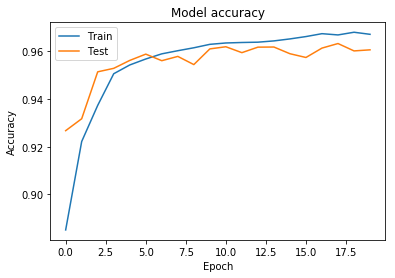

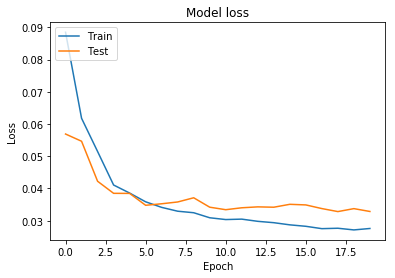

In [0]:
import matplotlib.pyplot as plt



# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
hist.summary()



NameError: ignored

In [0]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
import keras
from keras.optimizers import RMSprop, adam
from keras import optimizers
from keras.layers.advanced_activations import PReLU


num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

  
  



def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
     
    
    
    
    input_img = Input(shape = (28, 28, 1))
    tower_1 = Conv2D(64, (1,1), padding='same', activation=PReLU())(input_img)
    tower_x = Conv2D(64, (3,3), padding='same', activation=PReLU())(tower_1)
    tower_y = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_x)
    tower_y = Dropout(0.25)(tower_y)
    tower_z = Conv2D(64, (1,1), padding='same', activation=PReLU())(tower_y)
    tower_a = Conv2D(64, (3,3), padding='same', activation=PReLU())(tower_z)
    tower_a = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_a)
    tower_a = Dropout(0.25)(tower_a)
    
  
    tower_2 = MaxPooling2D(pool_size=(4, 4), padding='same')(tower_x)
    tower_2 = Dropout(0.25)(tower_2)
    
    tower_3 = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_z)
    tower_3 = Dropout(0.25)(tower_3)
    
    
#     tower_3 = Conv2D(64, (1,1), padding='same', activation='elu')(input_img)
#     tower_3 = Conv2D(64, (5,5), padding='same', activation='elu')(tower_3)
#     tower_3 = MaxPooling2D(pool_size=(2, 2), padding='same')(tower_3)
#     tower_3 = Dropout(0.25)(tower_3)
    
#     tower_4 = MaxPooling2D(pool_size=(2, 2), padding='same')(input_img)
#     tower_4 = Dropout(0.25)(tower_4)
    
    
    
    
    
    
    output = keras.layers.concatenate([tower_a, tower_2, tower_3], axis = 3)
    output = Flatten()(output)
#     out    = Dense(10, activation='softmax')(output)
    out    = Dense(64, activation='softmax')(output)
    
   

    
    
    
    
    model = Model(inputs = input_img, outputs = out)
    print(model.summary())
    return model
    

  
  


  

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.astype('float32')
x_test = x_test.reshape(10000,28,28,1)
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
# rms = RMSprop()
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=contrastive_loss, optimizer=adam, metrics=[accuracy])

hist = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 64)   128         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 64)   0           conv2d_3[0][0]                   
____________________________________________________________________________________________